In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light47_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Mar  8 23:50:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 71%   62C    P2   234W / 370W |   7989MiB / 24268MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 31%   

In [3]:
save_dir = 'save/light47_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0  save_10000  save_10988  save_5000


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 10988

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 201.4MiB
TTS size 195.1MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 10988
10988
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.018942975997924806


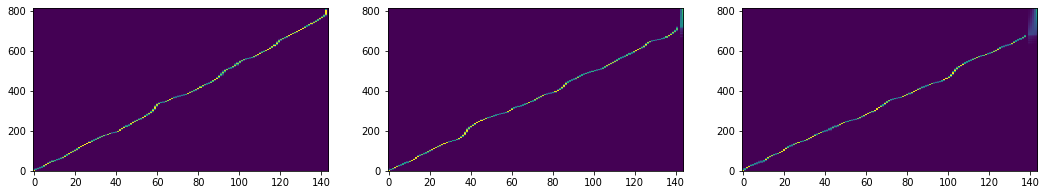

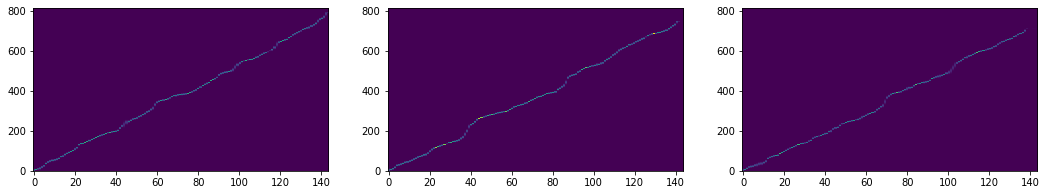

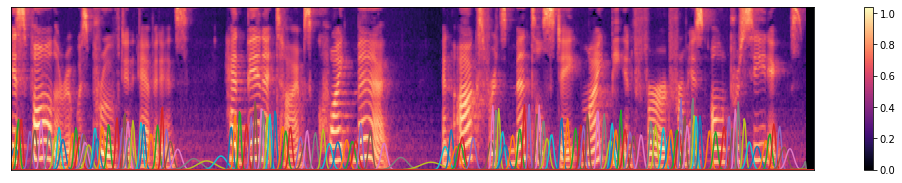

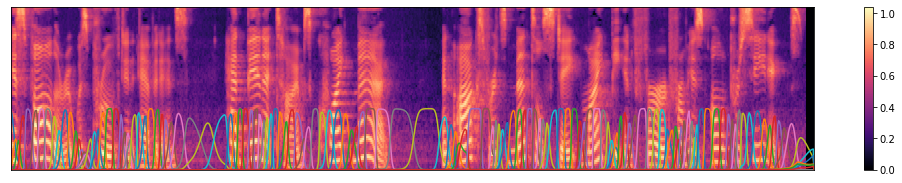

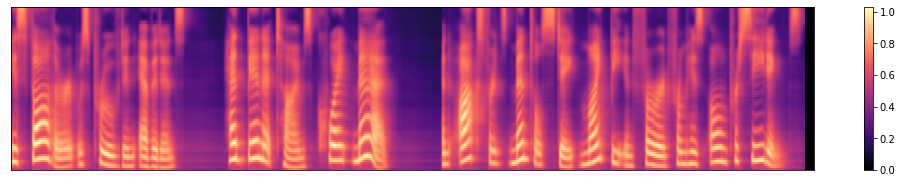

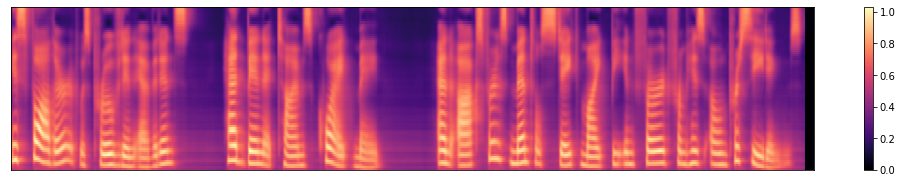

tensor(0.6654, device='cuda:0')
step : 28801 stt : 0.2213 tts : 0.1050 recon : 0.0031 kl : 0.0018 beta : 0.5761
tensor(2.2062, device='cuda:0')
step : 28802 stt : 0.2329 tts : 0.1317 recon : 0.0032 kl : 0.0018 beta : 0.5761
tensor(0.7080, device='cuda:0')
step : 28803 stt : 0.1933 tts : 0.1121 recon : 0.0034 kl : 0.0018 beta : 0.5761
tensor(0.6162, device='cuda:0')
step : 28804 stt : 0.1869 tts : 0.1068 recon : 0.0030 kl : 0.0017 beta : 0.5762
tensor(0.8618, device='cuda:0')
step : 28805 stt : 0.2038 tts : 0.1071 recon : 0.0031 kl : 0.0018 beta : 0.5762
tensor(0.7178, device='cuda:0')
step : 28806 stt : 0.1990 tts : 0.1063 recon : 0.0031 kl : 0.0017 beta : 0.5762
tensor(0.6417, device='cuda:0')
step : 28807 stt : 0.1900 tts : 0.1132 recon : 0.0030 kl : 0.0017 beta : 0.5762
tensor(0.7179, device='cuda:0')
step : 28808 stt : 0.1801 tts : 0.1052 recon : 0.0030 kl : 0.0017 beta : 0.5762
tensor(0.6038, device='cuda:0')
step : 28809 stt : 0.2474 tts : 0.1136 recon : 0.0035 kl : 0.0018 beta :

KeyboardInterrupt: 

In [28]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), tts_outputs["stt_alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            _stt_alignments = tts_outputs["stt_alignments"].data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 30)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(np.maximum(_y[index], 0))
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(np.maximum(_s[index, :, :_y.shape[2]], 0))
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [29]:
logger.save(step, model, optimizer)

saved save/light47_model/save_28833


['While he had drawn some attention to himself and had actually appeared on two radio programs, he had been attacked by Cuban exiles and arrested,', 'and the question, as part of the whole subject of capital punishment, had been referred to a royal commission in January eighteen sixty-four.', 'the supply of which was, however, limited, and there were not always enough to give bedding to all. The stock was diminished by theft;', 'The circulatory system distributes these foods. In animals foods prepared for absorption in the stomach and intestine (by digestion)', 'If he had been successful and had been apprehended even for routine questioning, his apartment would undoubtedly have been searched,', "Bishop, whose real name was Head, married a half-sister of Williams'. Williams was a professional resurrectionist, or body-snatcher,", 'return to it for lunch and then again at night, his mother having trained him to do that rather than to play with other children.', 'All are forced to make con

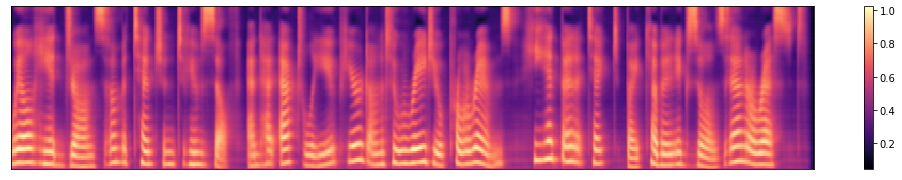

In [25]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    print(batch['strings'])
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [26]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


alignment 0.03
random 0.01
last_conv 0.39
z_proj 0.01
cond 0.05
up 0.07
encode 0.22
pad 0.00
enc_conv 0.05
enc_lstm 0.16


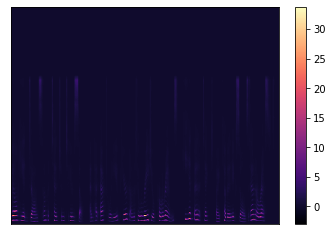

In [27]:
def denormalize(x):
    return np.exp(x * -np.log(1e-5) + np.log(1e-5))

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)